<a target="_blank" href="https://colab.research.google.com/github/IngCarlaPezzone/Clase-Machine-Learning/blob/main/Clase%208/093_ml_dt.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ML - Decision Trees

Seguimos en nuestra aventura aprendiendo nuevos algoritmos de *Machine Learning*. Anteriormente hemos hablado ya de algoritmos como la regresión lineal y *Suport Vector Machines*, y ahora es el turno de conocer los árboles de decisión, o *Decision Trees* en inglés. Este tipo de algoritmo, que es la base de uno de los modelos más usados en ML, los *Random Forest* (que veremos mas adelante), es capaz de llevar a cabo tareas de clasificación, regresión e incluso tareas con múltiples outputs. Además, es un modelo muy sencillo y explicable lo que lo hace ideal para aquellas tareas en las que la explicabilidad sea esencial (como aplicaciones médicas, entre otras).

## Entrenando y visualizando árboles de decisión

Vamos a ver un primer ejemplo de entrenamiento de un árbol de decisión en nuestro querido dataset Iris. En *Scikit-Learn*, puedes usar el modelo [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier).

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

Ahora, podemos usar la librería [graphviz](https://github.com/xflr6/graphviz) para visualizar nuestro modelo.

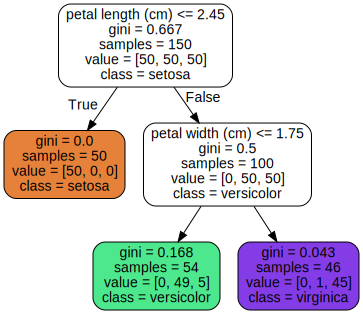

In [3]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file="iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file("iris_tree.dot")

A la hora de hacer predicciones con un árbol de decision empezaremos en el nodo raíz (*root node* en inglés), en este caso haciendo la pregunta: ¿es la longitud del pétalo menor o igual que 2.45 cm? En caso afirmativo, nos moveremos al nodo de la izquierda, y como todas las muestras del dataset pertenecen a la misma clase (setosa) podemos parar en este nodo terminal (o *leaf node* en inglés). En el caso contrario, nos moveremos hacia el nodo de la derecha. En este caso, al seguir teniendo muestras de varias clases, podemos hacernos otra pregunta: ¿Es el ancho del pétalo menor o igual que 1.75cm? De nuevo, en caso afirmativo, nos moveremos al siguiente node de la izquierda. Y, en caso contrario, al de la derecha. Como ya hemos alcanzado la profundidad máxima permitida, ambos nodos son terminales (en este caso incurriendo en varios errores de clasificación).

Como puedes ver, los árboles de decisión pueden trabajar con datasets pequeños, no necesitan normalización de los datos y son interpretables (sabemos en cada nodo el motivo por el cual una muestra se clasifica de una manera u otra).

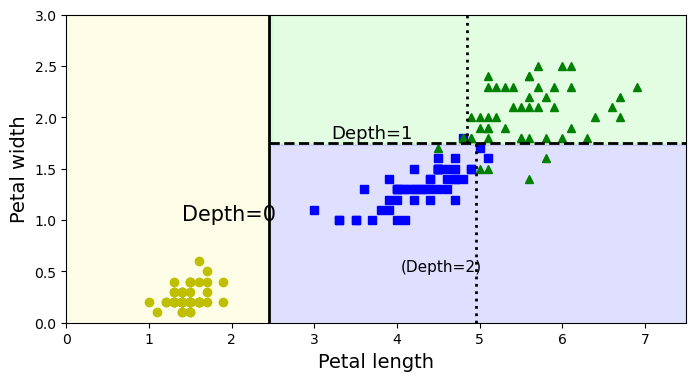

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt 
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.show()

También es posible estimar la probabilidad de que una muestra pertenezca a una clase en particular. Para ello usaremos el ratio entre las diferentes muestras de entrenamiento en el nodo en concreto.

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

La pregunta ahora es, ¿y cómo sabe el modelo que características usar en cada nodo y qué valores usar para tomar la decisión? La respuesta es el algoritmo *CART*.

## El algoritmo CART


El algoritmo CART (*Classification and Regression Tree* algorithm en inglés) se basa en la idea de ir dividiendo de manera consecutiva los datos de entrenamiento en dos grupos usando una única característica $k$ y un valor $t_k$. ¿Qué clase y valor usar? Aquel par que produzca la división más pura.

La pureza de un nodo se mide mediante el valor de impureza *Gini* 

\begin{equation}
  G_i = 1 - \sum_{k=1}^n p_{i,k}^2
\end{equation}

donde $p_{i,k}$ es el ratio de instancias de la clase $k$ en el nodo $i^{th}$ y $n$ es el número de clases.

La función de pérdida para la clasificación con el algoritmo CART se define de la siguiente manera:

\begin{equation}
  J(k, t_k) = \frac{m_{\textrm{left}}}{m} G_{\textrm{left}} + \frac{m_{\textrm{right}}}{m} G_{\textrm{right}}
\end{equation}

donde $G_{\textrm{left}/\textrm{right}}$ mide la impureza del grupo *left/right* y $m_{\textrm{left}/\textrm{right}}$ es el número de muestras en el grupo *left/right*.

Una vez el algoritmo ha sido capaz de dividir el dataset en dos, se repite el mismo proceso de manera iterativa para cada una de las divisiones hasta que se alcance una profundidad máxima o bien sea imposible reducir la impureza de un nodo.

## Regularización

Debido a la naturaleza del algoritmo, los árboles de decisión son capaces de adaptarse perfectamente a cualquier dataset, resultando en *overfitting*. Esto se debe a que siempre podemos ir añadiendo nuevas condiciones de decisión hasta llegar a separar cada instancia por separado. Para evitar esto, tenemos varias alternativas:

1. Limitar la profundidad del árbol.
2. Restringir el número mínimo de muestras necesarias para crear una nueva división.
3. Definir el número mínimo de muestras que un nodo terminal debe tener.
4. Definir el número máximo de nodos terminales.
5. Definir el número máximo de características evaluadas para dividir un nodo.

Otra opción es la conocida como *pruning*, que consiste en entrenar un árbol de decisión sin ningún tipo de restricción y luego eliminar todos aquellos nodos innecesarios. 

Todos estos valores pueden ser definidos a la hora de instanciar el modelo a través de los diferentes parámetros (que puedes encontrar en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)). Como siempre, la mejor manera de encontrar la mejor combinación de estos parámetros será usar algún algoritmo de optimización de hyperparámetros (grid search, random search, etc).

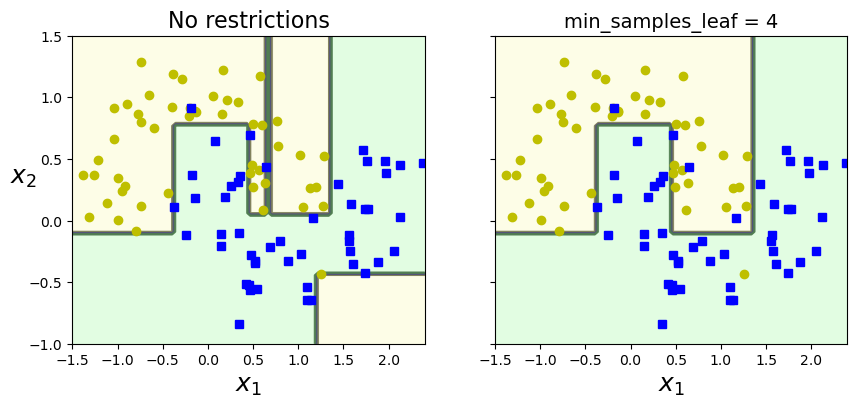

In [7]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")
plt.show()

## Regresión

Los árboles de decisión pueden usarse también para tareas de regresión. Para ello, tendrás que usar el modelo [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html?highlight=decisiontreeregressor#sklearn.tree.DecisionTreeRegressor).

In [8]:
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

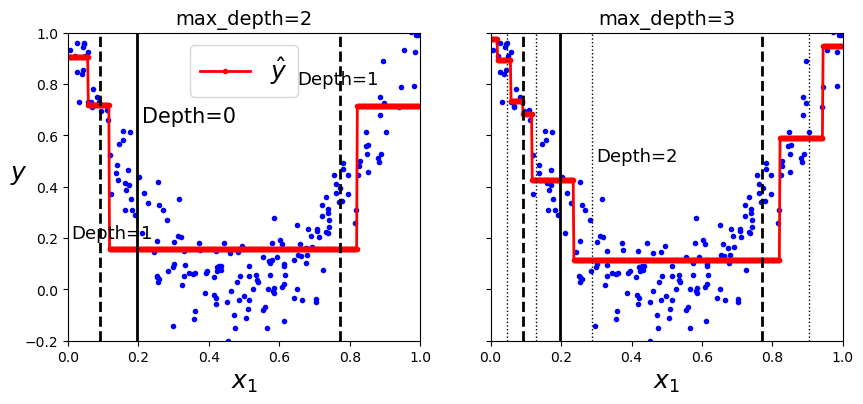

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)
plt.show()

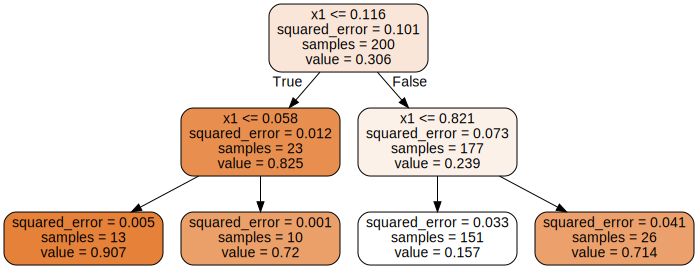

In [10]:
export_graphviz(
        tree_reg1,
        out_file="regression_tree.dot",
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

Source.from_file("regression_tree.dot")

La idea es la misma que para clasificación, pero ahora cada nodo terminal tiene un valor asignado igual al valor promedio de todas las muestras que pertenecen al nodo.

Para entrenar un árbol de decisión para regresión podemos usar el algoritmo CART, pero en vez de minimizar la impureza ahora minimizaremos el error medio cuadrático (MSE).

\begin{equation}
  J(k, t_k) = \frac{m_{\textrm{left}}}{m} MSE_{\textrm{left}} + \frac{m_{\textrm{right}}}{m} MSE_{\textrm{right}}
\end{equation}

donde $MSE_{\textrm{node}} = \sum_{i \in \textrm{node}} (\hat{y}_{\textrm{node}} - y^{(i)})^2$ and $\hat{y}_{\textrm{node}} = \frac{1}{m_{\textrm{node}}} \sum_{i \in \textrm{node}} y^{(i)}$.

De la misma manera, el modelo puede hacer *overfitting* si no usamos técnicas de regularización.

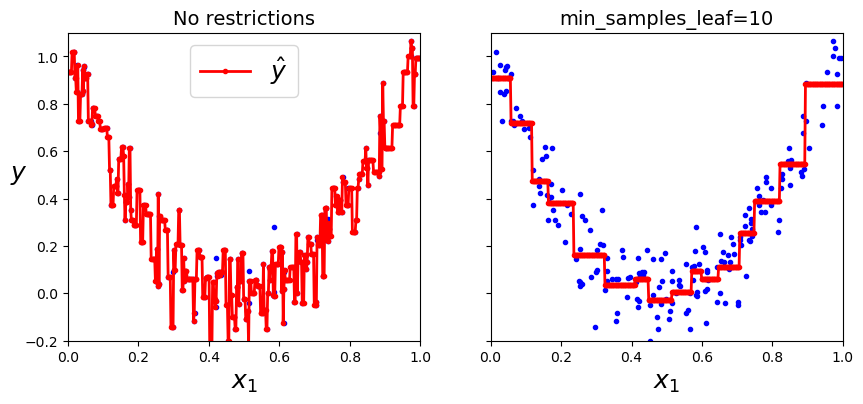

In [11]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)
plt.show()

## Limitaciones

Si bien los árboles de decisión son modelos simples, interpretables, versátiles y potentes, son muy sensible a pequeñas variaciones en los datos.

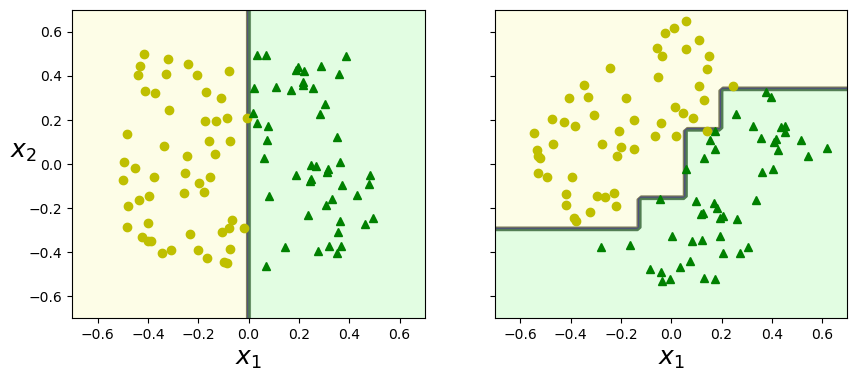

In [12]:
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.ylabel("")
plt.show()

Estos problemas pueden aliviarse usando PCA (de lo que hablaremos mas adelante) o bien usando *Random Forest*, un algoritmo basado en la idea de promediar las predicciones de muchos árboles de decisión (muy utilizado en la práctica).

## Random Forest

Empecemos entrenando un árbol de decisión en el siguiente dataset.

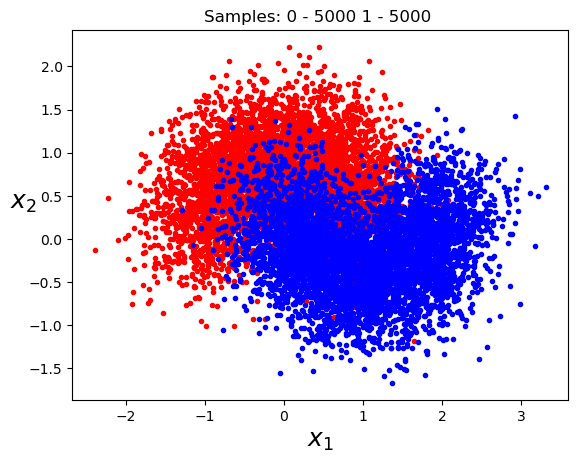

In [13]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

def plot_moons(X, y):
  plt.plot(X[y == 0][:, 0], X[y == 0][:, 1], '.r')
  plt.plot(X[y == 1][:, 0], X[y == 1][:, 1], '.b')
  plt.xlabel(r"$x_1$", fontsize=18)
  plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
  plt.title(f'Samples: 0 - {np.sum(y == 0)} 1 - {np.sum(y == 1)} ')

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

plot_moons(X, y)

Para ello, primero separaremos el dataset en training y test.

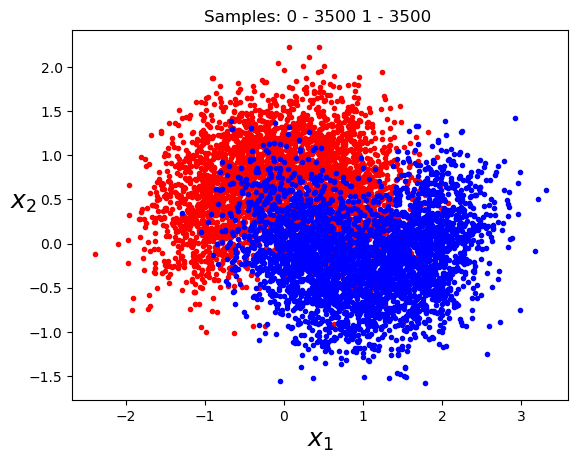

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

plot_moons(X_train, y_train)

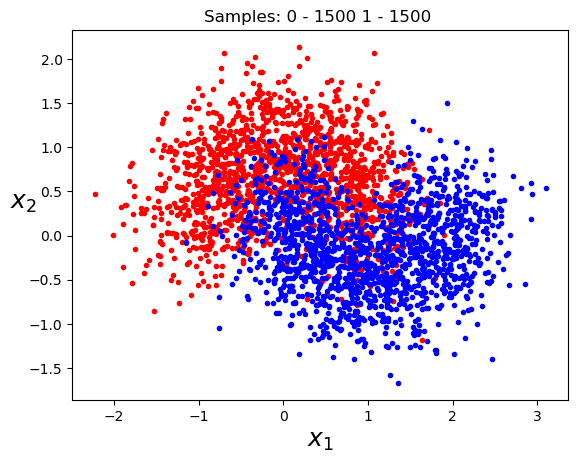

In [15]:
plot_moons(X_test, y_test)

Usando *grid search* y *cross-validation* vamos a entrenar un buen árbol de decisión.

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

params = {
    'max_leaf_nodes': list(range(2,50)),
    'min_samples_split': [2, 3, 4]
    # ....
}

grid_search = GridSearchCV(tree, params, cv=10, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [18]:
grid_search.best_params_

{'max_leaf_nodes': 36, 'min_samples_split': 2}

In [19]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.8643333333333333

¿Cómo podemos mejorar estos resultados? ¡Con un bosque lleno de árboles! Para ello, vamos a generar 1000 subdivisiones de nuestro dataset, cada una de ellas con solo 100 muestras.

In [20]:
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=1000, train_size=200, random_state=42)

mini_sets = []
for train_ixs, test_ixs in rs.split(X_train):
  X_mini_train = X_train[train_ixs]
  y_mini_train = y_train[train_ixs]
  mini_sets.append((X_mini_train, y_mini_train))

Subset: 340


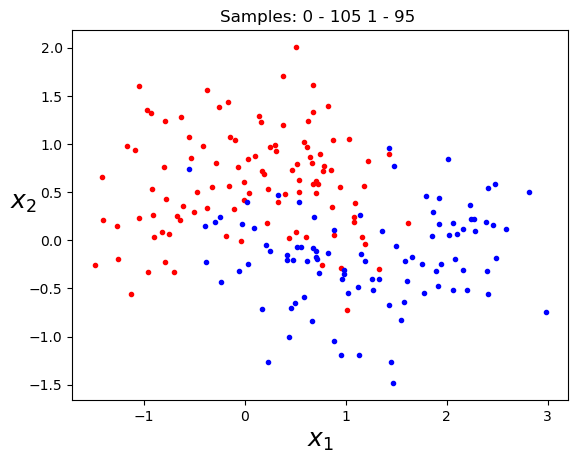

In [21]:
import random


ix = random.randint(0, 1000)
plot_moons(*mini_sets[ix])
print(f'Subset: {ix}')

Ahora entrenaremos un árbol de decisión en cada una de las divisiones. 

In [22]:
forest, accs = [], []
for X_mini_train, y_mini_train in mini_sets:
  tree = DecisionTreeClassifier(**grid_search.best_params_)
  tree.fit(X_mini_train, y_mini_train)
  y_pred = tree.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  forest.append(tree)
  accs.append(acc)
np.mean(accs)

0.8064083333333333

Ups, parece que no ha mejorado... Y es que los parámetros que estamos usando para cada modelo han sido encontrados para todo el dataset, por lo que su uso en los diferentes subsets no es óptimo. Para aprovechar la potencia de todos los árboles de decisión lo que haremos será generar las predicciones de cada árbol y quedarnos con las más frecuentes, usando una técnica de ensamblado conocida como votación por mayoría (de lo que hablaremos en más detalle mas adelante).

In [23]:
from scipy.stats import mode

Y_pred = []
for tree in forest:
  y_pred = tree.predict(X_test)
  Y_pred.append(y_pred)
Y_pred = np.array(Y_pred)
Y_pred.shape

(1000, 3000)

In [24]:
majority_votes, n_votes = mode(Y_pred, axis=0)
majority_votes.shape

(1, 3000)

In [25]:
accuracy_score(y_test, majority_votes.reshape([-1]))

0.866

Ahora sí hemos mejorado el resultado anterior. Esto demuestra el poder del ensamblado, o usar las predicciones de varios modelos para obtener una mejor solución que usando los modelos por separado. ¡Felicidades! has entrenado tu primer *Random Forest*.

## Resumen

En este post hemos introducido un nuevo algoritmo de ML: los árboles de decisión. Este modelo es versátil, potente, sencillo e interpretable. No necesita que normalicemos los datos y funciona subdividiendo los datos de manera iterativa en dos grupos mediante una condición determinada en alguna de las características. También hemos visto el algoritmo CART, que nos permite entrenar árboles de decisión tanto para tareas de clasificación como de regresión. Para terminar, hemos introducido el concepto de *ensamblado* con un *Random Forest*, que es muy útil para sobreponerse a las limitaciones de los árboles de decisión (de lo que hablaremos en el siguiente post).